In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pipeline
import random
import itertools

In [5]:
demographic_df = pd.read_sas('../data/raw_1.sas7bdat')
demo_df = pipeline.clean_demographic(demographic_df)

In [82]:
gambling_series_df = pd.read_sas('../data/raw_2.sas7bdat')
gam_df = pipeline.clean_gambling(gambling_series_df)

In [7]:
rg_intervention_df = pd.read_sas('../data/raw_3.sas7bdat')
rg_info = pipeline.clean_rg_info(rg_intervention_df)

# DEMOGRAPHIC EDA

In [5]:
demo_df

,rg,country,language,gender,birth_year,registration_date,first_deposit_date
user_id,,,,,,,
2975944,1,germany,german,m,1970,2006-06-02,2006-06-09
9822065,1,germany,german,f,1963,2009-11-21,2009-11-21
9622454,1,france,french,f,1981,2009-10-19,2009-10-19
9619356,1,italy,italian,f,1975,2009-10-18,2009-10-18
9593498,1,germany,german,f,1990,2009-10-14,2009-10-14
...,...,...,...,...,...,...,...
107292,0,austria,german,m,1975,2000-07-09,2000-07-09
92140,0,austria,german,m,1973,2000-06-25,2000-06-25
80281,0,austria,german,m,1970,2000-06-13,2000-06-13


In [6]:
bins = [2000,2001,2002,2003,2004,2005,2006,2008]
groups = demo_df.groupby(pd.cut(demo_df.registration_date.dt.year, bins))
groups.count()
groups.mean()

,rg,birth_year
registration_date,,
"(2000, 2001]",0.592593,1970.851852
"(2001, 2002]",0.413333,1972.586667
"(2002, 2003]",0.483871,1974.443548
"(2003, 2004]",0.489362,1976.285106
"(2004, 2005]",0.550835,1975.600910
"(2005, 2006]",0.520047,1976.653302
"(2006, 2008]",0.528839,1977.835997


In [7]:
gam_df.head()
gam_df['weekend'] = gam_df['date'].dt.dayofweek >= 4
gb_day_in_week = gam_df.groupby('weekend')
gb_day_in_week.mean()

,user_id,product_type,turnover,hold,num_bets
weekend,,,,,
False,3.230706e+06,3.698906,347.728142,16.763593,46.320172
True,3.193773e+06,3.384506,338.787361,15.741385,43.302686


In [8]:
user_id = 5799772
pipeline.make_ts(gam_df, user_id, 10)

,user_id,product_type,turnover,hold,num_bets,weekend,hold_cum
2000-01-01,5799772,10,0.0,0.0,0,0,0.0
2000-01-02,5799772,10,0.0,0.0,0,0,0.0
2000-01-03,5799772,10,0.0,0.0,0,0,0.0
2000-01-04,5799772,10,0.0,0.0,0,0,0.0
2000-01-05,5799772,10,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...
2010-11-26,5799772,10,0.0,0.0,0,0,0.0
2010-11-27,5799772,10,0.0,0.0,0,0,0.0
2010-11-28,5799772,10,0.0,0.0,0,0,0.0
2010-11-29,5799772,10,0.0,0.0,0,0,0.0


In [26]:
def add_weighted_bets(gam_df, w_means = None):
    if not w_means:
        w_means = gam_df.groupby('product_type')['num_bets'].mean()
        w_means /= w_means[1]
    gam_df['weighted_bets'] = 0
    for product_type in gam_df['product_type'].unique():
        mask = gam_df['product_type'] == product_type
        gam_df.loc[mask,'weighted_bets'] = gam_df[mask]['num_bets'] / w_means[product_type]
    return gam_df

In [27]:
gam_test = add_weighted_bets(gam_df)

In [24]:
has_hold_data = [1,2,4,8,17]
def accum_by_date(gam_data, user_id, product_types = has_hold_data):
    '''Accumulates the turnover+hold across all product_types'''
    mask = (gam_data['user_id'] == user_id) & (gam_data['product_type'].isin(product_types))
    series = gam_data[mask].groupby('date').sum()
    series = series.drop(["product_type","user_id"], axis = 1)
    reg_date = demo_df.loc[user_id].registration_date
    #last_gamble = series['date'].max()
    idx = pd.date_range(reg_date, '2010-11-30')
    series = series.reindex(idx, fill_value=0)
    #Move this out!
    series['weekend'] = pd.DatetimeIndex(series.index).dayofweek >= 4
    series['hold_cum'] = series['hold'].cumsum()
    return series.copy()

In [12]:
all_prods = list(range(1,30))
ts_acc = accum_by_date(gam_test, 5799772, all_prods)

In [13]:
ts_acc['weekend'] = pd.DatetimeIndex(ts_acc.index).dayofweek >= 4
ts_acc
ts_acc.groupby('weekend').count()

,turnover,hold,num_bets,weighted_bets,hold_cum
weekend,,,,,
False,599,599,599,599,599
True,450,450,450,450,450


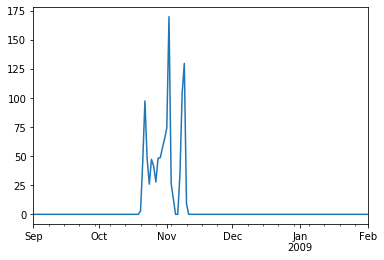

In [14]:
ts_acc['weighted_bets']['2008-09-01':'2009-02-01'].plot()

In [30]:
rg_ids = list(demo_df[demo_df['rg'] == 1].index)
no_rg_ids = list(demo_df[demo_df['rg'] == 0].index)

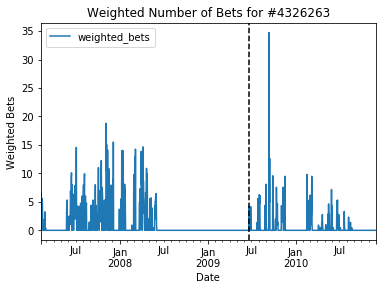

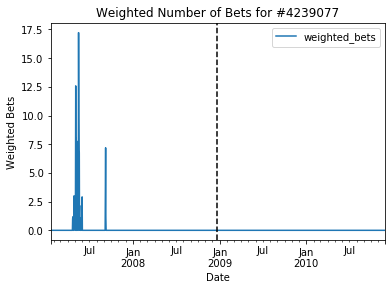

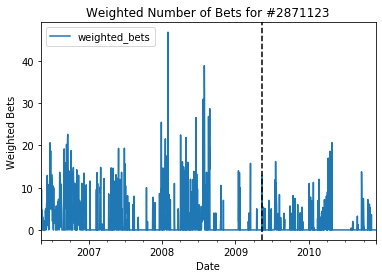

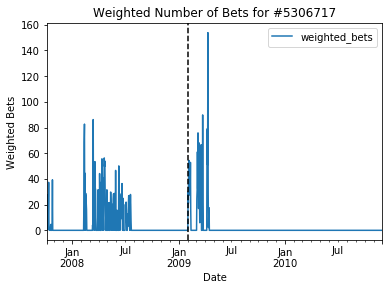

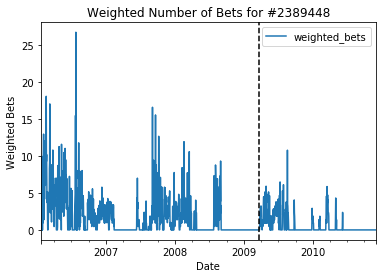

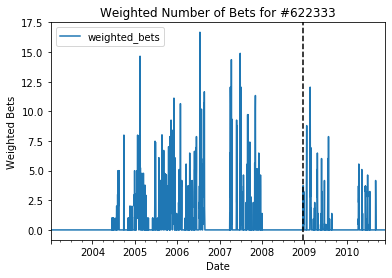

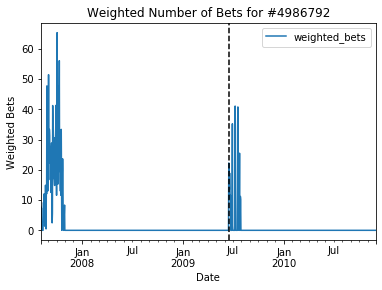

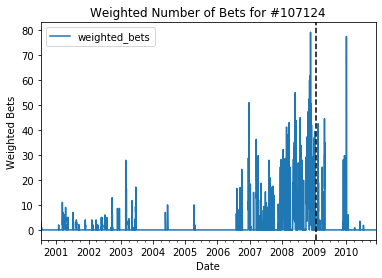

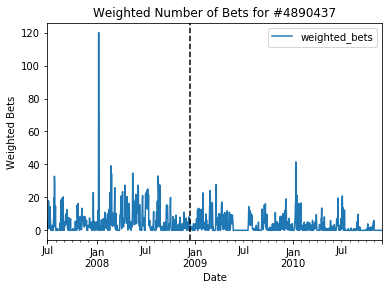

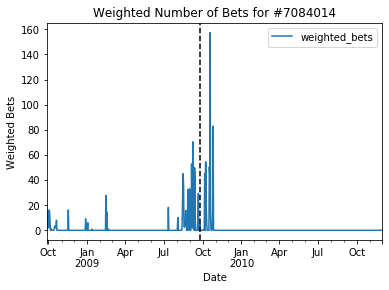

In [70]:
def plot_ts(ts, user_id, plt_column = 'hold_cum', rg_info = None):
    ts[plt_column].plot(label = plt_column)
    #ts['num_bets'].plot(label = "Cumulative Loss")
    if rg_info is not None and (user_id in rg_info.index):
        first_rg = rg_info.loc[user_id, 'first_date']
        rg_desc = rg_info.loc[user_id, 'ev_desc']
        inter_desc = rg_info.loc[user_id, 'inter_desc']
        plt.axvline(first_rg, linestyle = "--", color = 'black')
        #plt.axvline(first_rg, linestyle = "--", label = f'RG: {rg_desc}\nInt:{inter_desc}', color = 'black')
cr_mask = rg_info['event_type_first'] == 2
acc_cr_ids = list(rg_info[cr_mask].index)
#random.seed(123)
for _ in range(10):
    user_id = random.choice(rg_ids)
    all_prods = list(range(1,30))
    ts = accum_by_date(gam_test, user_id, all_prods)
    plot_ts(ts, user_id, plt_column = 'weighted_bets', rg_info = rg_info)
    plt.title(f'Weighted Number of Bets for #{user_id}')
    plt.xlabel("Date")
    plt.ylabel("Weighted Bets")
    plt.legend()
    plt.show()

In [17]:
clear_prior_block = [3324091,2336892,2874213, 4478231]
reported_prob_adv = [164641,3214045]

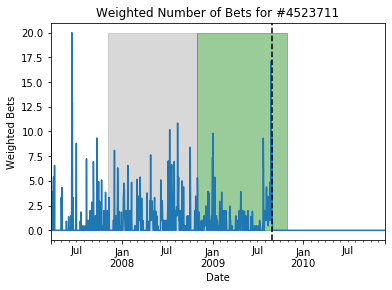

In [80]:
fig, ax = plt.subplots(1)
user_id = 4523711
all_prods = list(range(1,30))
ts = accum_by_date(gam_test, user_id, all_prods)
plot_ts(ts, user_id, plt_column = 'weighted_bets', rg_info = rg_info)
ax.set_title(f'Weighted Number of Bets for #{user_id}')
ax.set_xlabel("Date")
ax.set_ylabel("Weighted Bets")

cutoff = np.datetime64('2008-11-01')
ax.fill_between([cutoff - np.timedelta64(360, 'D'),cutoff],[20,20],color='gray',alpha=.3)
ax.fill_between([cutoff, cutoff + np.timedelta64(360, 'D')],[20,20],color='green',alpha=.4)
plt.show()

In [67]:
user_id = 3327778
all_prods = list(range(1,30))
#date_range = ['2008-02-01':'2008-02-28']
ts = accum_by_date(gam_test, user_id, all_prods)
rg_info.index
#rg_info[2169867]
# plot_ts(ts, user_id, plt_column = 'weighted_bets', rg_info = rg_info)
# plt.title(f'Weighted Number of Bets for #{user_id}')
# plt.xlabel("Date")
# plt.ylabel("Weighted Bets")
# plt.legend()
# plt.show()
# rg_info[user_id]
# ts.info()
# ts.index

KeyError: 2169867

In [74]:
rg_info.index
rg_info.loc[2169867]

events                                                 1
first_date                           2009-11-19 00:00:00
last_date                            2009-11-19 00:00:00
event_type_first                                       9
inter_type_first                                      18
ev_desc                            Request Partial Block
inter_desc          Requested Partial Block Not Possible
Name: 2169867, dtype: object

Let's compare RG flagged to non RG flagged

In [20]:
rg_ids = list(demo_df[demo_df['rg'] == 1].index)
no_rg_ids = list(demo_df[demo_df['rg'] == 0].index)

In [21]:
rg_time_series = {}
all_prods = list(range(1,30))
for user_id in rg_ids:
    rg_time_series[user_id] = accum_by_date(gam_test, user_id, all_prods)

In [22]:
acc = 0
for user_id in rg_time_series:
    acc += rg_time_series[user_id].hold_cum[-1]
acc /= len(rg_time_series)
acc

5847.023986916271

In [23]:
nrg_time_series = {}
all_prods = list(range(1,30))
for user_id in no_rg_ids:
    nrg_time_series[user_id] = accum_by_date(gam_test, user_id, all_prods)

In [24]:
acc = 0
for user_id in nrg_time_series:
    acc += nrg_time_series[user_id].hold_cum[-1]
acc /= len(nrg_time_series)
acc

378.8520896504892

**Make Training Matrix**
* Target: Whether an RG event happens in the next three months
* We plan to use the following features:
    * Weekly hold data from past three months
    * Monthly hold data from past twelve
    * Summaries of history
        * Mean Activity
        * Max activity
        * Mean bets
        * Max bet
        * Weekend/Week Activity
        * Rolling windows
    

In [179]:
test = gam_df.copy()
x = test.join(demo_df, 'user_id')
y = x.groupby(['rg']).count()
z = x.groupby(['rg', 'product_type']).count()
y.loc[0,'user_id']
#Interesting, substantially more live-action than fixed-odds
product_use_norg = z.loc[0, 'user_id']/y.loc[0, 'user_id']
product_use_rg = z.loc[1, 'user_id']/y.loc[1, 'user_id']
product_use_rg, product_use_norg
product_use_rg[1]/product_use_rg[2]
product_use_norg[1]/product_use_norg[2]

2.5841988625744268

In [25]:
user = 2062223
ts_test = rg_time_series[2062223]

,turnover,hold,num_bets,weekend,weighted_bets,hold_cum
2005-10-26,0.0,0.0,0,False,0.000000,0.000
2005-10-27,304.0,25.0,2,False,0.051835,25.000
2005-10-28,7.0,-0.8,5,True,2.316016,24.200
2005-10-29,7.4,5.8,5,True,2.316016,30.000
2005-10-30,0.0,0.0,0,True,0.000000,30.000
...,...,...,...,...,...,...
2010-11-26,0.0,0.0,0,True,0.000000,27898.165
2010-11-27,0.0,0.0,0,True,0.000000,27898.165
2010-11-28,0.0,0.0,0,True,0.000000,27898.165
2010-11-29,0.0,0.0,0,False,0.000000,27898.165


In [26]:
ts_test.groupby('weekend').sum()

,turnover,hold,num_bets,weighted_bets,hold_cum
weekend,,,,,
False,256950.2171,12775.6771,34674,5881.653353,1.700581e+07
True,159110.2279,15122.4879,20367,5927.682039,1.275660e+07


In [27]:
week_ts = ts_test.resample('W')

In [76]:
x = week_ts.sum().drop("hold_cum", axis = 1)
x['2010-09-09':'2010-10-09']
df = x['weighted_bets']
df.rolling(5).sum()

2005-10-30           NaN
2005-11-06           NaN
2005-11-13           NaN
2005-11-20           NaN
2005-11-27    131.097651
                 ...    
2010-11-07      3.242423
2010-11-14      3.242423
2010-11-21      0.926407
2010-11-28      0.926407
2010-12-05      0.926407
Freq: W-SUN, Name: weighted_bets, Length: 267, dtype: float64

In [29]:
month_ts = ts_test.resample('M')
month_ts.sum()

,turnover,hold,num_bets,weekend,weighted_bets,hold_cum
2005-10-31,318.40,30.00,12,3.0,4.683868,139.200
2005-11-30,9438.61,397.00,1142,12.0,146.936619,4751.410
2005-12-31,12519.50,-88.00,2337,14.0,51.895119,7669.000
2006-01-31,3220.03,686.00,614,13.0,13.701738,22563.000
2006-02-28,19790.22,702.72,1640,12.0,79.285110,37808.500
...,...,...,...,...,...,...
2010-07-31,0.00,0.00,0,14.0,0.000000,863882.115
2010-08-31,0.00,0.00,0,13.0,0.000000,863882.115
2010-09-30,47.13,11.00,8,12.0,3.705626,836273.950
2010-10-31,48.00,10.00,5,15.0,2.316016,864433.115


In [30]:
user_mask = gam_df['user_id'] == user
gam_df[user_mask].groupby('product_type').count()

,user_id,date,turnover,hold,num_bets,weekend,weighted_bets
product_type,,,,,,,
1,601,601,601,601,601,601,601
2,906,906,906,906,906,906,906
4,6,6,6,6,6,6,6
6,11,11,0,0,11,11,11
7,2,2,0,0,2,2,2
8,142,142,142,142,142,142,142
14,161,161,0,0,161,161,161
15,30,30,0,0,30,30,30
19,2,2,0,0,2,2,2


In [31]:
x = gam_df.groupby('user_id').mean()
x['rg'] = False
for user_id in x.index:
    if user_id in rg_ids:
        x.loc[user_id, 'rg'] = True

In [32]:
x

,product_type,turnover,hold,num_bets,weekend,weighted_bets,rg
user_id,,,,,,,
31965,2.042005,85.580042,10.378040,9.178862,0.444444,3.873417,True
32639,1.015152,9.488517,2.524742,1.000000,0.454545,0.991867,False
36822,8.145161,7.528308,-0.233231,3.354839,0.322581,0.715177,False
36916,1.495726,216.604561,15.121394,81.854701,0.512821,4.716987,True
38386,1.168831,4.206921,1.427086,2.285714,0.441558,2.211040,True
...,...,...,...,...,...,...,...
9821694,10.000000,NaN,NaN,15.000000,0.666667,0.843682,False
9822065,6.275000,8.274000,1.369750,33.375000,0.262500,4.363776,True
9822269,1.000000,35.241877,35.241877,1.500000,1.000000,1.500000,False


In [33]:
x.groupby('rg').mean()

,product_type,turnover,hold,num_bets,weekend,weighted_bets
rg,,,,,,
False,2.907941,88.747338,6.101446,18.453652,0.472873,2.633354
True,3.830005,390.073958,19.300520,49.598947,0.454328,5.747101


In [34]:
rg_info.head()

,events,first_date,last_date,event_type_first,inter_type_first,ev_desc,inter_desc
user_id,,,,,,,
2169867,1,2009-11-19,2009-11-19,9,18,Request Partial Block,Requested Partial Block Not Possible
7035862,1,2009-11-15,2009-11-15,9,18,Request Partial Block,Requested Partial Block Not Possible
5911218,1,2009-11-08,2009-11-08,9,18,Request Partial Block,Requested Partial Block Not Possible
5872708,1,2009-11-03,2009-11-03,9,18,Request Partial Block,Requested Partial Block Not Possible
5746942,2,2009-10-18,2009-11-03,9,18,Request Partial Block,Requested Partial Block Not Possible


In [13]:
test = demo_df.join(rg_info, 'user_id')
rg_users = test[(test.rg == 1) & (test.event_type_first != 2)]
rg_users['sign_to_RG'] = rg_users['first_date'] - rg_users['registration_date']

/home/alexrose/Downloads/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


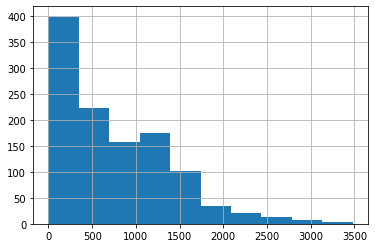

In [22]:
rg_users['sign_to_RG'].dt.days.hist()

In [99]:
mask = gam_df['user_id'] == 2062223
user = gam_df[mask]
holds = user.groupby('product_type').sum()
holds['hold'][2]

18288.019699999986

In [96]:
gam_df[mask]

,user_id,date,product_type,turnover,hold,num_bets
112525,2062223,2005-11-02,1,37.05,37.05,27
112526,2062223,2005-11-05,1,31.00,31.00,27
112527,2062223,2005-11-06,1,0.00,0.00,0
112528,2062223,2005-11-19,1,10.00,10.00,2
112529,2062223,2005-11-20,1,3.00,3.00,1
...,...,...,...,...,...,...
966166,2062223,2008-05-26,15,NaN,NaN,53
967974,2062223,2008-06-19,15,NaN,NaN,109
968217,2062223,2008-06-05,15,NaN,NaN,125
979637,2062223,2007-06-16,19,NaN,NaN,1
